LightGBM Model

Importing Libraries

In [32]:
import lightgbm as lgb
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc,matthews_corrcoef,f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
from sklearn.metrics import mean_squared_error
import time 
from joblib import Parallel, delayed

In [33]:
file_path = "../../../data/processed/train_data.csv"
df = pd.read_csv(file_path)
file_path2= "../../../data/processed/test_data.csv"
df2 = pd.read_csv(file_path2)

Model Functions

In [71]:


# Function to bin continuous data
def bin_data(X, n_bins=255):
    #create bins for the data and initialize the binned data with zeros
    binned_X = np.zeros_like(X, dtype=np.int32)
    bin_edges = []

    for feature in range(X.shape[1]):
        # Compute bin edges for the current feature using max and min values for min to max values of the feature
        edges = np.linspace(np.min(X[:, feature]), np.max(X[:, feature]), n_bins + 1)
        bin_edges.append(edges)

        # Assign each value to a bin
        binned_X[:, feature] = np.digitize(X[:, feature], edges) - 1  # Subtract 1 to make bins 0-indexed

    return binned_X, bin_edges

# Compute residuals and Hessians
def compute_residuals_and_hessians(y_true, y_pred):
    residuals = y_pred - y_true
    hessians = y_pred * (1 - y_pred)  # For binary classification we calcul the hessian for the log loss 
    return residuals, hessians

# Find the best split using binned data
def find_best_split_binned(binned_X, gradients, hessians, n_bins=255):
    # Compute the gain for each feature and each bin for best split
    def compute_gain_for_feature(feature_idx):
        # Count gradients and Hessians for each bin
        grad_per_bin = np.zeros(n_bins)
        hess_per_bin = np.zeros(n_bins)
        # For each bin, compute the sum of gradients and Hessians
        for bin_idx in range(n_bins):
            # Create a mask  to filter data points belonging to the current bin
            mask = binned_X[:, feature_idx] == bin_idx 
            grad_per_bin[bin_idx] = gradients[mask].sum() # Get the sum of gradients for the current bin
            hess_per_bin[bin_idx] = hessians[mask].sum() 

        # Compute cumulative sums to evaluate all possible splits
        cum_grad = np.cumsum(grad_per_bin) 
        cum_hess = np.cumsum(hess_per_bin)
        # Compute the total gradients and Hessians 
        total_grad = cum_grad[-1]
        total_hess = cum_hess[-1]

        # Gain for each split (excluding the last bin) because we need at least one data point in the right child
        gains = (cum_grad[:-1] ** 2 / (cum_hess[:-1] + 1e-10)) + \
                ((total_grad - cum_grad[:-1]) ** 2 / (total_hess - cum_hess[:-1] + 1e-10))
        # Find the best split with the maximum gain
        best_bin = np.argmax(gains)
        best_gain = gains[best_bin]

        return best_gain, feature_idx, best_bin
    # Compute the gain for each feature and each bin in parallel using joblib for parallel processing optimization
    results = Parallel(n_jobs=-1)(
        delayed(compute_gain_for_feature)(feature) for feature in range(binned_X.shape[1])
    )
    best_gain, best_feature, best_bin = max(results, key=lambda x: x[0])
    return best_feature, best_bin, best_gain

# Recursively split the tree
def split_node_binned(binned_X, gradients, hessians, depth, max_depth, max_leaves, bin_edges):
    # If the depth is equal to the maximum depth or if the number of data points is less than or equal to 1, return the leaf value
    if depth >= max_depth or len(binned_X) <= 1:
        # Compute the leaf value as the negative sum of gradients divided by the sum of Hessians
        leaf_value = -gradients.sum() / hessians.sum() if hessians.sum() > 0 else 0
        return {"leaf_value": leaf_value}

    best_feature, best_bin, best_gain = find_best_split_binned(binned_X, gradients, hessians)
    # If the best gain is less than or equal to 0, return the leaf value
    if best_gain <= 0:
        leaf_value = -gradients.sum() / hessians.sum() if hessians.sum() > 0 else 0
        return {"leaf_value": leaf_value}

    # Split the data into left and right children
    left_mask = binned_X[:, best_feature] <= best_bin
    right_mask = ~left_mask

    return {
        "feature": best_feature,
        "split": bin_edges[best_feature][min(best_bin + 1, len(bin_edges[best_feature]) - 1)],  # Fix index out of bounds
        "left": split_node_binned(binned_X[left_mask], gradients[left_mask], hessians[left_mask], 
                                  depth + 1, max_depth, max_leaves, bin_edges),
        "right": split_node_binned(binned_X[right_mask], gradients[right_mask], hessians[right_mask], 
                                   depth + 1, max_depth, max_leaves, bin_edges),
    }

# Train the LightGBM model
def train_lightgbm_with_bins(X, y, learning_rate=0.1, num_trees=10, max_depth=3, max_leaves=31, n_bins=255):
    start = time.time()
    # Bin the data
    binned_X, bin_edges = bin_data(X, n_bins=n_bins)
    initial_prediction = np.log(np.mean(y) / (1 - np.mean(y)))
    y_pred = np.full_like(y, initial_prediction, dtype=float)

    trees = []

    for _ in range(num_trees):
        gradients, hessians = compute_residuals_and_hessians(y, expit(y_pred))

        tree = split_node_binned(binned_X, gradients, hessians, depth=0, max_depth=max_depth, 
                                 max_leaves=max_leaves, bin_edges=bin_edges)
        trees.append(tree)

        predictions_update = np.zeros_like(y)
        for i in range(len(y)):
            node = tree
            while "leaf_value" not in node:
                if X[i, node["feature"]] < node["split"]:
                    node = node["left"]
                else:
                    node = node["right"]
            predictions_update[i] = node["leaf_value"]

        y_pred += learning_rate * predictions_update

    print(f"Training Time: {time.time() - start:.4f} seconds")
    return trees, initial_prediction, bin_edges

# Predict with LightGBM using bins
def predict_lightgbm_with_bins(X, trees, initial_prediction):
    start = time.time()
    
    y_pred = np.full(X.shape[0], initial_prediction, dtype=float)
    for tree in trees:
        predictions_update = np.zeros(X.shape[0])
        # For each data point, traverse the tree to get the leaf value
        for i in range(X.shape[0]):
            # Traverse the tree to get the leaf value
            node = tree
            while "leaf_value" not in node: 
                # If the feature value is less than the split value, go to the left child, otherwise go to the right child
                if X[i, node["feature"]] < node["split"]:
                    node = node["left"]
                else:
                    node = node["right"]
            predictions_update[i] = node["leaf_value"]

        y_pred += predictions_update

    print(f"Testing Time: {time.time() - start:.4f} seconds")
    return expit(y_pred)


Implemented the lightgbm model with the training and prediction functions and applied it to the train and test data

Training model without Features selection

In [56]:

X_train= df.drop(columns=['target']).values
y_train= df['target'].values
X_test= df2.drop(columns=['target']).values
y_test= df2['target'].values

start_train_without_fs = time.time()
trained_trees_without_fs, initial_prediction_without_fs,_ = train_lightgbm_with_bins(
    X_train, y_train, learning_rate=0.1,
    num_trees=40,
    max_depth=6,
    max_leaves=178,
    n_bins=138
)
end_train_without_fs = time.time()
training_time_without_fs = end_train_without_fs - start_train_without_fs

start_test_without_fs = time.time()
y_pred_test_without_fs = predict_lightgbm_with_bins(X_test, trained_trees_without_fs, initial_prediction_without_fs)
end_test_without_fs = time.time()
testing_time_without_fs = end_test_without_fs - start_test_without_fs
y_pred_test_without_fs = (y_pred_test_without_fs >= 0.5).astype(int)

accuracy= accuracy_score(y_test, y_pred_test_without_fs)


print(f"Accuracy sur le jeu de test : {accuracy * 100:.2f}%")

Training Time: 4096.0555 seconds
Testing Time: 0.1528 seconds
Accuracy sur le jeu de test : 93.97%


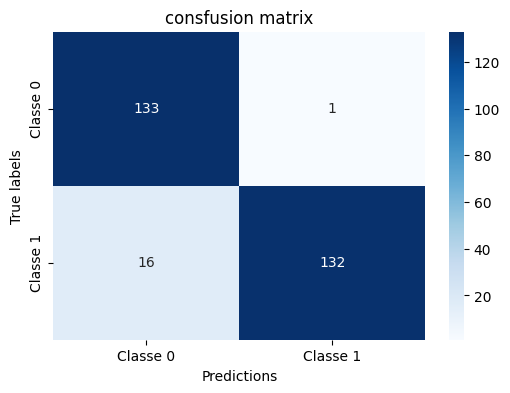

In [58]:
conf_matrix = confusion_matrix(y_test, (y_pred_test_without_fs >= 0.5).astype(int))

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.title("consfusion matrix")
plt.xlabel("Predictions")
plt.ylabel("True labels")
plt.show()


In [64]:
class_report = classification_report(y_test, (y_pred_test_without_fs >= 0.5).astype(int))
print("Rapport de Classification :")
print(class_report)

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       134
           1       0.99      0.89      0.94       148

    accuracy                           0.94       282
   macro avg       0.94      0.94      0.94       282
weighted avg       0.95      0.94      0.94       282



AUC : 94.22%
MCC : 0.88


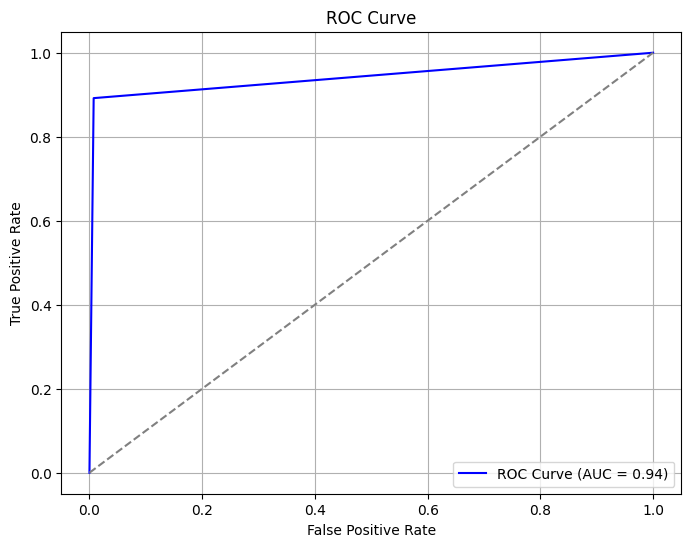

In [65]:

y_prob = y_pred_test_without_fs 
y_pred = (y_pred_test_without_fs >= 0.5).astype(int) 

fpr, tpr, thresholds = roc_curve(y_test, y_prob)  
roc_auc = auc(fpr, tpr)                           

# Calcul MCC
mcc = matthews_corrcoef(y_test, y_pred)

print(f"AUC : {roc_auc:.2%}")
print(f"MCC : {mcc:.2f}")


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
# Load datasets
df_train = pd.read_csv("../../../data/processed/train_filtered.csv")
df_test = pd.read_csv("../../../data/processed/test_filtered.csv")

# Prepare training and testing data
X_train1 = df_train.drop(columns=['target']).values
y_train1 = df_train['target'].values
X_test1 = df_test.drop(columns=['target']).values
y_test1 = df_test['target'].values

# Train LightGBM model
start_train_with_fs = time.time()
trained_trees_with_fs, initial_prediction_with_fs,_ = train_lightgbm_with_bins(
    X_train1, y_train1,
    learning_rate=0.1,
    num_trees=40,
    max_depth=6,
    max_leaves=178,
    n_bins=138)
end_train_with_fs = time.time()
training_time_with_fs = end_train_with_fs - start_train_with_fs

# Test LightGBM model
start_test_with_fs = time.time()
y_pred_test_with_fs = predict_lightgbm_with_bins(X_test1, trained_trees_with_fs, initial_prediction_with_fs)
end_test_with_fs = time.time()
testing_time_with_fs = end_test_with_fs - start_test_with_fs

# Convert predicted probabilities to binary class labels
y_pred_test_with_fs = (y_pred_test_with_fs >= 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test1, y_pred_test_with_fs)

# Print results

print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Training Time: 177.2859 seconds
Testing Time: 0.0247 seconds
Accuracy on the test set: 93.97%


In [67]:
class_report = classification_report(y_test, (y_pred_test_with_fs >= 0.5).astype(int))
print("Rapport de Classification :")
print(class_report)

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       134
           1       0.96      0.92      0.94       148

    accuracy                           0.94       282
   macro avg       0.94      0.94      0.94       282
weighted avg       0.94      0.94      0.94       282



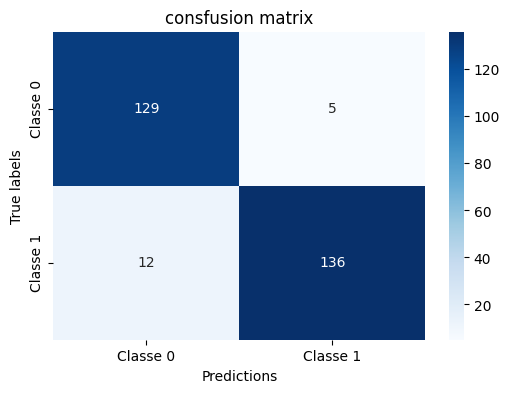

In [68]:
conf_matrix = confusion_matrix(y_test1, (y_pred_test_with_fs >= 0.5).astype(int))

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.title("consfusion matrix")
plt.xlabel("Predictions")
plt.ylabel("True labels")
plt.show()


AUC : 94.08%
MCC : 0.88


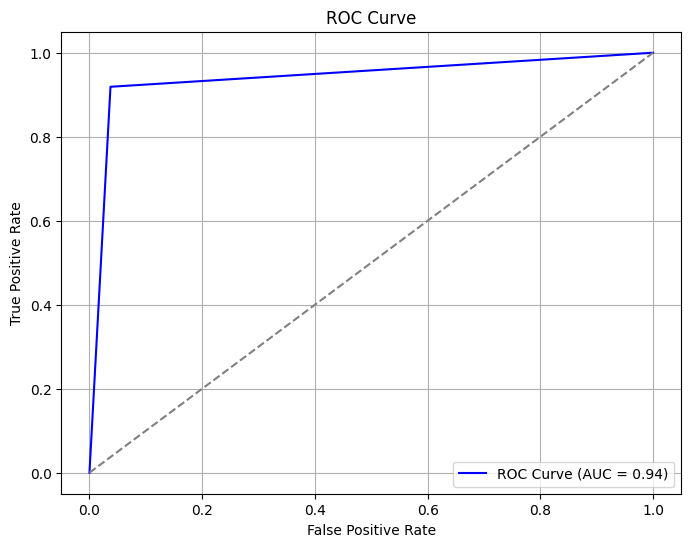

In [69]:

y_prob = y_pred_test_with_fs  
y_pred = (y_pred_test_with_fs >= 0.5).astype(int) 

fpr, tpr, thresholds = roc_curve(y_test1, y_prob)  # ROC
roc_auc = auc(fpr, tpr)                           # AUC

# Calcul MCC
mcc = matthews_corrcoef(y_test1, y_pred)

print(f"AUC : {roc_auc:.2%}")
print(f"MCC : {mcc:.2f}")


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


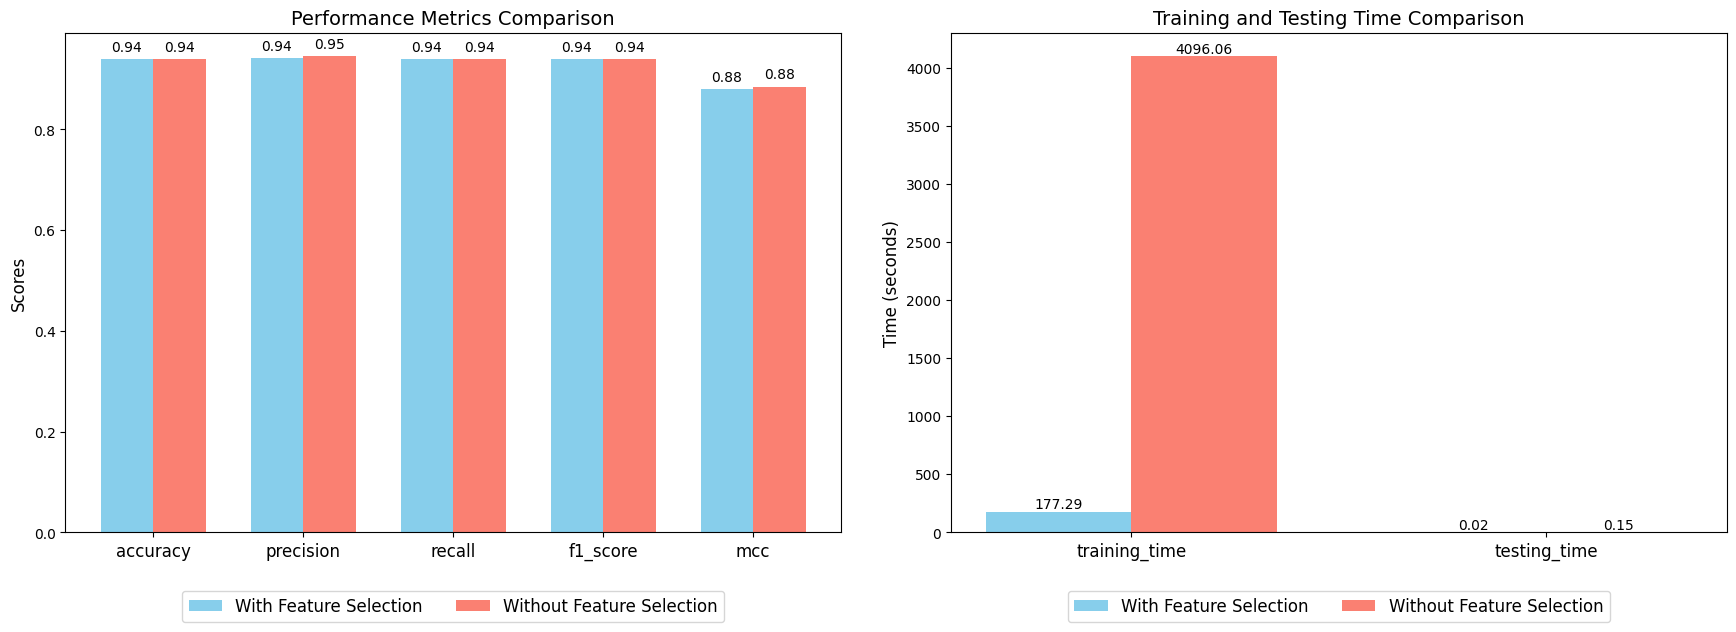

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report, matthews_corrcoef
)

# Compute performance metrics
# ========================
# With Feature Selection
class_report_with_fs = classification_report(y_test, y_pred_test_with_fs, output_dict=True)

metrics_with_fs = {
    "accuracy": accuracy_score(y_test, y_pred_test_with_fs),
    "precision": class_report_with_fs["weighted avg"]["precision"],
    "recall": class_report_with_fs["weighted avg"]["recall"],
    "f1_score": class_report_with_fs["weighted avg"]["f1-score"],
    "mcc": matthews_corrcoef(y_test, y_pred_test_with_fs),
    "training_time": training_time_with_fs,
    "testing_time": testing_time_with_fs,
}

# Without Feature Selection
class_report_without_fs = classification_report(y_test, y_pred_test_without_fs, output_dict=True)
metrics_without_fs = {
    "accuracy": accuracy_score(y_test, y_pred_test_without_fs),
    "precision": class_report_without_fs["weighted avg"]["precision"],
    "recall": class_report_without_fs["weighted avg"]["recall"],
    "f1_score": class_report_without_fs["weighted avg"]["f1-score"],
    "mcc": matthews_corrcoef(y_test, y_pred_test_without_fs),
    "training_time": training_time_without_fs,
    "testing_time": testing_time_without_fs,
}

# ========================
# Plotting the comparison
# ========================
performance_metrics = ["accuracy", "precision", "recall", "f1_score", "mcc"]
time_metrics = ["training_time", "testing_time"]

with_fs_performance = [metrics_with_fs[m] for m in performance_metrics]
without_fs_performance = [metrics_without_fs[m] for m in performance_metrics]

with_fs_time = [metrics_with_fs[m] for m in time_metrics]
without_fs_time = [metrics_without_fs[m] for m in time_metrics]

# Set up the bar chart parameters
x_perf = np.arange(len(performance_metrics))
x_time = np.arange(len(time_metrics))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# ========================
# Performance Metrics Plot
# ========================
rects1 = ax1.bar(x_perf - width / 2, with_fs_performance, width, label="With Feature Selection", color="skyblue")
rects2 = ax1.bar(x_perf + width / 2, without_fs_performance, width, label="Without Feature Selection", color="salmon")

ax1.set_ylabel("Scores", fontsize=12)
ax1.set_title("Performance Metrics Comparison", fontsize=14)
ax1.set_xticks(x_perf)
ax1.set_xticklabels(performance_metrics, fontsize=12)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=12)

# Add values to bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax1.text(
        rect.get_x() + rect.get_width() / 2.0,
        height + 0.01,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

# ========================
# Time Metrics Plot
# ========================
rects3 = ax2.bar(x_time - width / 2, with_fs_time, width, label="With Feature Selection", color="skyblue")
rects4 = ax2.bar(x_time + width / 2, without_fs_time, width, label="Without Feature Selection", color="salmon")

ax2.set_ylabel("Time (seconds)", fontsize=12)
ax2.set_title("Training and Testing Time Comparison", fontsize=14)
ax2.set_xticks(x_time)
ax2.set_xticklabels(time_metrics, fontsize=12)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=12)

# Add values to bars
for rect in rects3 + rects4:
    height = rect.get_height()
    ax2.text(
        rect.get_x() + rect.get_width() / 2.0,
        height ,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

fig.tight_layout(pad=3)
plt.show()
